In [1]:
import sys, time, os
sys.path.append("..")

from utils.Db import Db
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime 
from datetime import timedelta
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from utils.kalman_utils import pool_init, run_kalman, DEAD
from multiprocessing import Queue
from multiprocessing.pool import Pool
from stockstats import StockDataFrame

In [2]:
plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

In [3]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y')

db = Db("../cache")
df = db.get_symbols_as_dataframe(['AAPL'])
df['date_time'] = pd.to_datetime(df['date_time'])
df.head()

,symbol,date_time,unix_time,adjusted_close,close,high,low,open,volume
0,AAPL,1998-01-02,883717200,0.5125,16.25,16.25,13.50,13.63,6411700.0
1,AAPL,1998-01-05,883976400,0.5009,15.88,16.56,15.19,16.50,5820300.0
2,AAPL,1998-01-06,884062800,0.5974,18.94,20.00,14.75,15.94,16182800.0
3,AAPL,1998-01-07,884149200,0.5519,17.50,19.00,17.31,18.81,9300200.0
4,AAPL,1998-01-08,884235600,0.5737,18.19,18.62,16.94,17.44,6910900.0


# Support Vector Regression

Can fit a line exactly to the data

In [4]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
dates = df['unix_time'].as_matrix()
dates = np.reshape(dates, (len(dates), 1))
prices = df['adjusted_close'].as_matrix()
svr_rbf.fit(dates, prices)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>


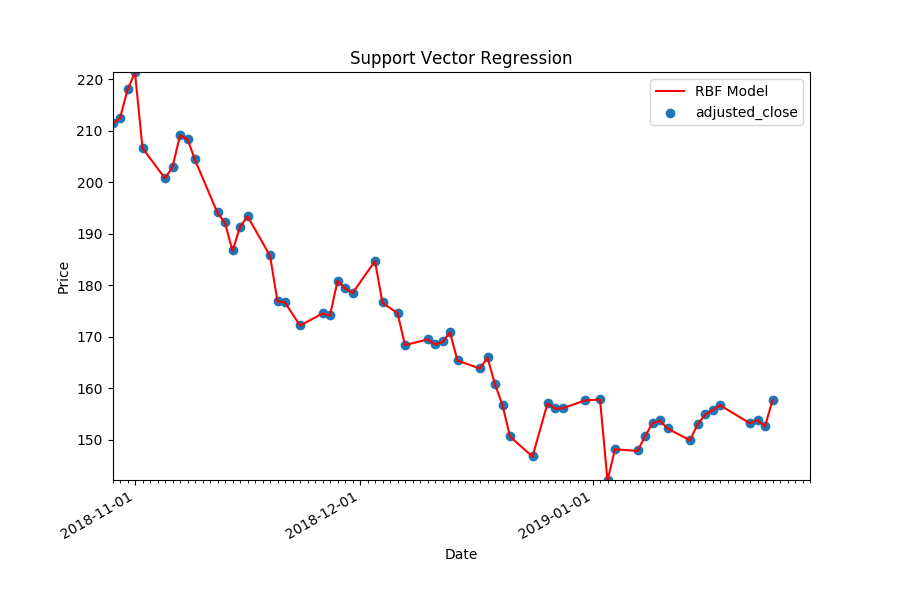

In [23]:
fig, ax = plt.subplots()
ax.scatter(df['date_time'].as_matrix(), df['adjusted_close'])
ax.plot(df['date_time'].as_matrix(), svr_rbf.predict(dates), color='red', label='RBF Model')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(days)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = df.tail(60)['date_time'].dt.to_pydatetime()[0]
right = df.tail(1)['date_time'].dt.to_pydatetime()[0] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = df.tail(60)['adjusted_close'].min()
top = df.tail(60)['adjusted_close'].max()
ax.set_ylim(top=top, bottom=bottom)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# Kalman Filter

Uses the equations of kinematics to predict motion in the X direction. Will track the movement very close to the data.

In [6]:
kalman_data = df[['unix_time', 'adjusted_close', 'date_time']].as_matrix()
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([
    [kalman_data[0][1]],
    [0.0]
], dtype=float)
kf.F = np.array([
    [1., 1.],
    [0., 1.]
])
kf.H = np.array([[1., 0.]])
kf.P *= 1000.
kf.R = 5
kf.Q = Q_discrete_white_noise(2, 1., .1)

data_2 = [kf.x[0][0]]
for x in kalman_data[1:]:        
    kf.predict()
    kf.update(np.array([[x[1]]], dtype=float))
    val = kf.x[0][0]   
    data_2.append(val)

<IPython.core.display.Javascript object>


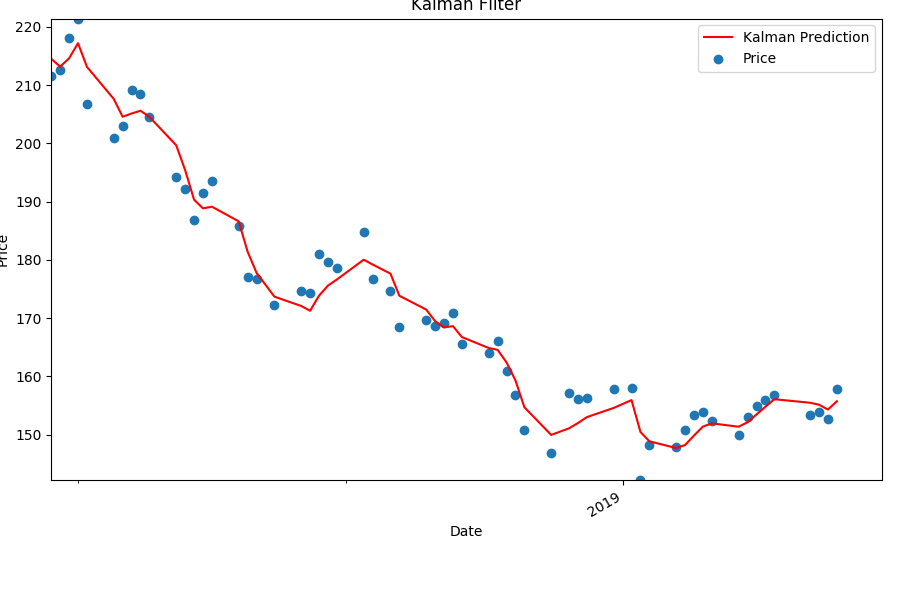

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_kfvals = kalman_data[:,2]
y_kfvals = kalman_data[:,1].tolist()
ax.scatter(x_kfvals, y_kfvals, label='Price')
ax.plot(x_kfvals, data_2, label='Kalman Prediction', color='red')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = kalman_data[-60,2]
right = kalman_data[-1,2] + timedelta(days=5)
ax.set_xlim(left=left, right=right)
bottom = kalman_data[-60:,1].min()
top = kalman_data[-60:,1].max()
ax.set_ylim(top=top, bottom=bottom)
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Kalman Filter')
plt.legend()    

# Predict one week using Kalman Filter

Showing the last 60 days. Using the entire dataset to build the kalman filter. Predicting values for the next 5 days. 

In [20]:
last_few = kalman_data[-60:,:]

unix_dates = last_few[:,0].reshape(-1, 1)
x_vals = last_few[:,2]
y_vals = last_few[:,1].tolist()

last_few_kalman = data_2[-60:]
next_vals = [last_few_kalman[-1]]
next_dates = [x_vals[-1]]
last_date = last_few[-1,2]

for i in range(5):
    kf.predict()
    kval = kf.x[0][0]
    next_date = last_date + timedelta(days=i+1)
    next_vals.append(kval)
    next_dates.append(next_date)

<IPython.core.display.Javascript object>


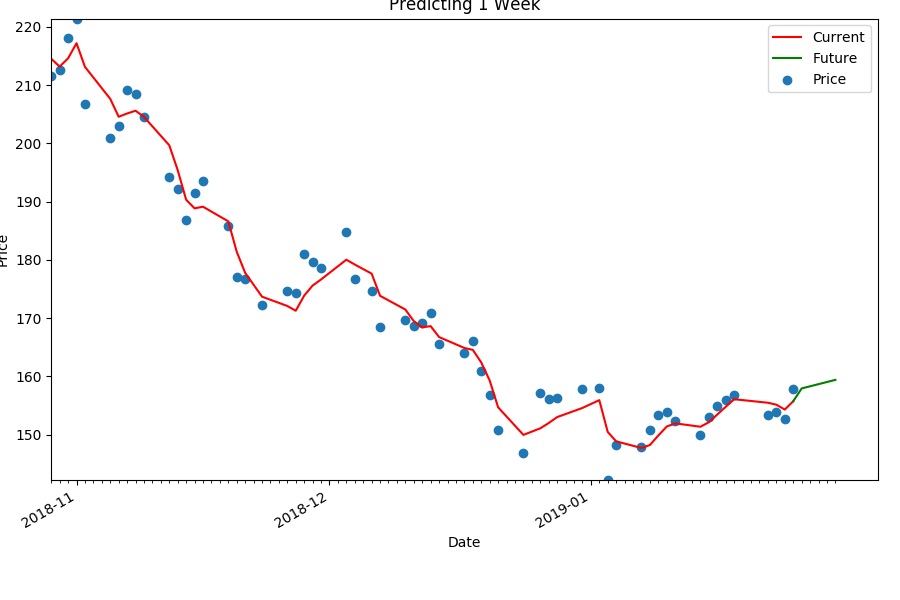

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(x_vals, last_few_kalman, label='Current', color='red')
ax.plot(next_dates, next_vals, label='Future', color='green')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(days)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
left = last_few[0,2]
right = last_few[-1,2] + timedelta(days=10)
ax.set_xlim(left=left, right=right)
bottom = last_few[:,1].min()
top = last_few[:,1].max()
ax.set_ylim(top=top, bottom=bottom)
fig.tight_layout()
fig.autofmt_xdate()
plt.title('Predicting 1 Week')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Predict 5 days ahead and 30 days ahead

In [10]:
def run_kalman_future(future):
    queue = Queue()
    pool = Pool(initializer=pool_init, initargs=(queue,), processes=os.cpu_count())
    
    pool_args = []
    for i in range(1, len(kalman_data)):
        if i % future == 0:
            pool_args.append((i, future, kalman_data))

    pool.map(run_kalman, pool_args)

    returned = 0
    results = []
    while True:
        out = queue.get(True)
        if out != DEAD:
            results.append(list(out))
        returned += 1
        if returned == len(pool_args):
            break
    results = sorted(results, key=lambda x: x[0])
    df = pd.DataFrame(results, columns=['row', 'date_time', 'prediction', 'error'])
    
    pool.close()
    return df['date_time'].as_matrix(), df['prediction'].as_matrix(), df['error'].as_matrix()

In [11]:
# kalman_pd5, kalman_p5, kalman_e5 = run_kalman(5)
if __name__ == '__main__':
    kalman_pd5, kalman_p5, kalman_e5 = run_kalman_future(5)

<IPython.core.display.Javascript object>


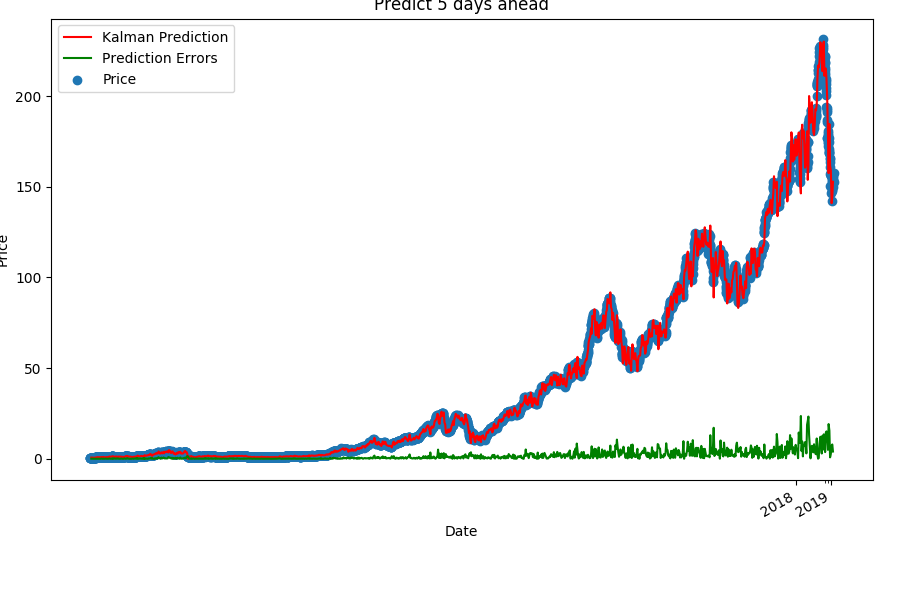

Mean prediction Error: 1.79354099954
Std prediction Error: 2.86462839727


In [18]:
plt.rcParams["figure.figsize"] = [9, 6]

fig = plt.figure()
ax = fig.add_subplot(111)

x_30vals = kalman_data[:,2]
y_30vals = kalman_data[:,1].tolist()
ax.scatter(x_30vals, y_30vals, label='Price')
ax.plot(kalman_pd5, kalman_p5, label='Kalman Prediction', color='red')
ax.plot(kalman_pd5, kalman_e5, label='Prediction Errors', color='green')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predict 5 days ahead')
plt.legend() 


print("Mean prediction Error: " + str(np.mean(np.array(kalman_e5))))
print("Std prediction Error: " + str(np.std(kalman_e5)))

In [13]:
if __name__ == '__main__':
    kalman_pd30, kalman_p30, kalman_e30 = run_kalman_future(30)

<IPython.core.display.Javascript object>


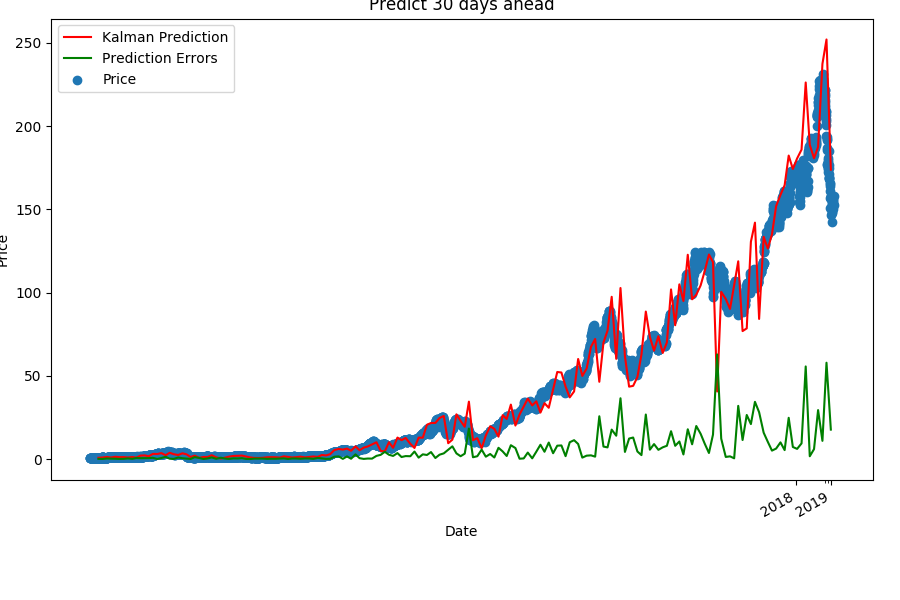

Mean prediction Error: 6.21975322893
Std prediction Error: 10.1377225504


In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_vals = kalman_data[:,2]
y_vals = kalman_data[:,1].tolist()
ax.scatter(x_vals, y_vals, label='Price')
ax.plot(kalman_pd30, kalman_p30, label='Kalman Prediction', color='red')
ax.plot(kalman_pd30, kalman_e30, label='Prediction Errors', color='green')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predict 30 days ahead')
plt.legend() 

print("Mean prediction Error: " + str(np.mean(np.array(kalman_e30))))
print("Std prediction Error: " + str(np.std(kalman_e30)))

<IPython.core.display.Javascript object>


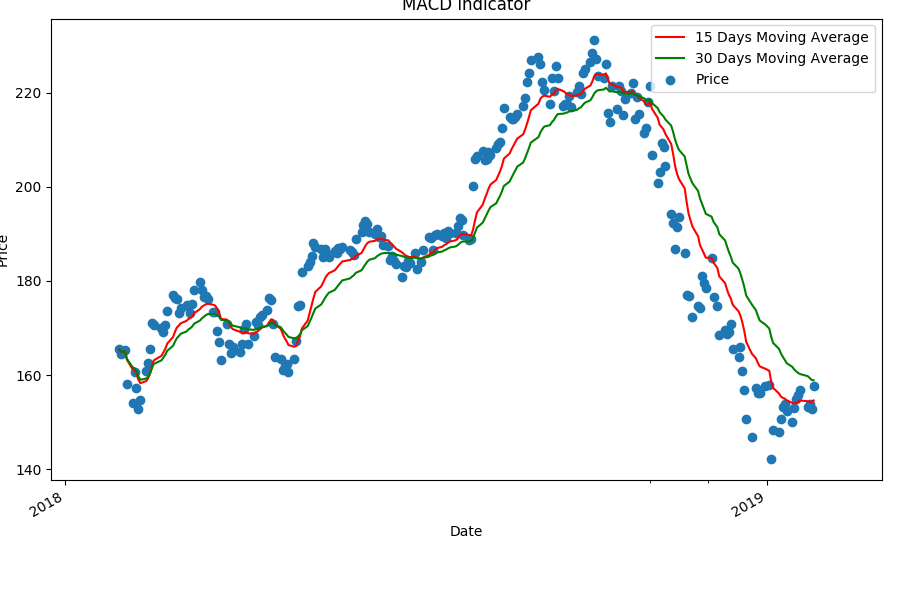

In [16]:
ewmdf = df[df['date_time'] > datetime.now() - timedelta(days=365)]
ewmdf.index = ewmdf['date_time']
days_15 = ewmdf['adjusted_close'].ewm(span=15).mean()
days_15 = days_15.reset_index()
days_30 = ewmdf['adjusted_close'].ewm(span=30).mean()
days_30 = days_30.reset_index()

scatter_data = ewmdf[['unix_time', 'adjusted_close', 'date_time']].as_matrix()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(scatter_data[:, 2], scatter_data[:, 1].tolist(), label='Price')
ax.plot(days_15['date_time'], days_15['adjusted_close'], label='15 Days Moving Average', color='red')
ax.plot(days_30['date_time'], days_30['adjusted_close'], label='30 Days Moving Average', color='green')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.tight_layout()
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MACD indicator')
plt.legend()
plt.show()